In [1]:
import os
os.chdir("../")

In [2]:
import cv2
from matplotlib import pyplot as plt

In [3]:
from src.hold_detection.detectron.Detector import InstanceSegmentator
from src.hold_matching.Matcher import Matcher
from src.utils.config import load_config
from src.utils.detectron_utils import plot_predictions

In [4]:
global_config, local_config = load_config()

In [5]:
image_file_name = "PXL_20230412_192542807.MP.jpg"
video_file_name = "pose_estimation_1.mp4"
model_config_file_name = "hold-detector_cfg.pickle"

In [6]:
image = cv2.imread(local_config['PATH']['raw_routes'] + "test_set\\" + image_file_name)
image = cv2.resize(image, (0, 0), fx=0.75, fy=0.75)
image_height = image.shape[0]
image_width = image.shape[1]
print(image.shape)

(3024, 1701, 3)


In [7]:
frames = []
cap = cv2.VideoCapture(local_config['PATH']['raw_videos'] + video_file_name)
while(cap.isOpened):
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        break
cap.release()
print(frames[0].shape)

(1920, 1080, 3)


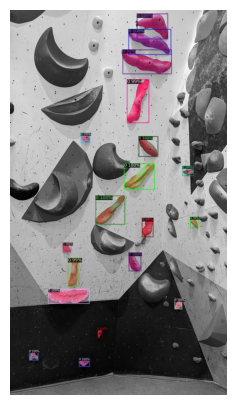

In [11]:
indices = [0, 3, 13, 14, 15, 18, 19, 20, 23, 25, 28, 30, 34, 40, 50, 54, 59, 64, 65]

image_detector = InstanceSegmentator(
    local_config['PATH']['config']+model_config_file_name,
    "model_final.pth",
    0.9,
    0.2
)
image_predictions = image_detector.predict(image)
plotted_image = plot_predictions(image.copy(), image_predictions["instances"][indices])
fig = plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(plotted_image)
plt.show()

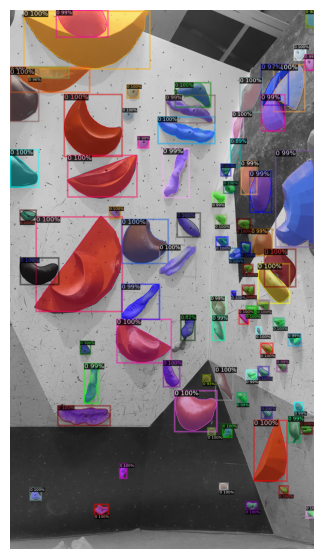

In [12]:
initial_frame = frames[0].copy()

video_detector = InstanceSegmentator(
    local_config['PATH']['config']+model_config_file_name,
    "model_final.pth",
    0.8,
    0.5
)
video_predictions = video_detector.predict(frames[0])

plotted_frame = plot_predictions(initial_frame.copy(), video_predictions["instances"])
fig = plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(cv2.cvtColor(plotted_frame, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
matcher = Matcher()

video_frame_hold_kp_counts = {
    index: 0 for index in range(
        len(video_predictions["instances"])
    )
}
bb_margin = int(image_height * 0.01)
for hold_index in indices:
    bbox = (
        image_predictions["instances"][hold_index]
        .get("pred_boxes")
        .tensor
        .cpu()
        .numpy()[0]
    )
    

    hold_area = image[
        int(max(0, bbox[1]-bb_margin)):int(min(image_height, bbox[3]+bb_margin)),
        int(max(0, bbox[0]-bb_margin)):int(min(image_width, bbox[2]+bb_margin))
    ].copy()

    kp1, kp2, good_matches = matcher.match(hold_area, initial_frame, 0.9)
    matched_points = [
        kp2[match[0].trainIdx].pt
        for match in good_matches
    ]
    
    if len(matched_points) > 0:
        for index in range(len(video_predictions["instances"])):
            bbox = (
                video_predictions["instances"][index]
                .get("pred_boxes")
                .tensor
                .cpu()
                .numpy()[0]
            )       
            for point in matched_points:
                if (
                    bbox[0] < point[0] < bbox[2] and
                    bbox[1] < point[1] < bbox[3]
                ):
                    video_frame_hold_kp_counts[index] += 1

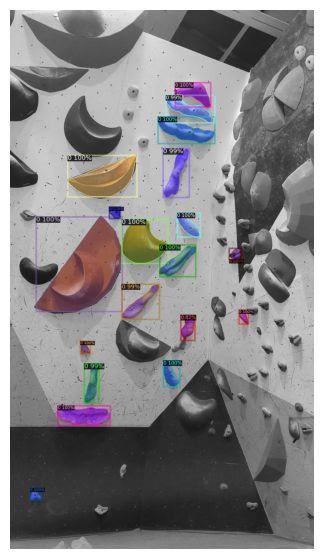

In [14]:
sorted_dict = sorted(
    video_frame_hold_kp_counts.items(), 
    key=lambda x: x[1], 
    reverse=True
)
hold_candidates = [key for key, v in sorted_dict[:len(indices)]]


plotted_frame = plot_predictions(initial_frame.copy(), video_predictions["instances"][hold_candidates])
fig = plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(cv2.cvtColor(plotted_frame, cv2.COLOR_BGR2RGB))
plt.show()